# 03 - Train and Deploy

In [2]:
import boto3
import sagemaker
import time
from time import strftime

boto_session = boto3.Session()
sagemaker_session = sagemaker.Session(boto_session=boto_session)
sm_client = boto3.client("sagemaker")
region = boto_session.region_name
bucket = sagemaker_session.default_bucket()
role = sagemaker.get_execution_role()
account = sagemaker_session.boto_session.client("sts").get_caller_identity()["Account"]

prefix = 'sagemaker-intel-dvc'

print(f"account: {account}")
print(f"bucket: {bucket}")
print(f"region: {region}")
print(f"role: {role}")

account: 546801796757
bucket: sagemaker-ap-south-1-546801796757
region: ap-south-1
role: arn:aws:iam::546801796757:role/sagemaker_manual_role


In [3]:
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role
from sagemaker.debugger import TensorBoardOutputConfig

Commit Hash: `efaaa7a6279dd82e5673476bc789cfd105cb7dae`

In [4]:
dvc_repo_url = "codecommit::ap-south-1://intl-emlo-s12"
dvc_branch = "processed-dataset"

In [5]:
bucket

'sagemaker-ap-south-1-546801796757'

In [6]:
tensorboard_output_config = TensorBoardOutputConfig(
    s3_output_path=f's3://{bucket}/sagemaker-intel-logs',
    container_local_output_path='/opt/ml/output/tensorboard'
)

In [63]:
pt_estimator = PyTorch(
    base_job_name="training-intel-dataset-emlo",
    source_dir="emlov2-session-12",
    entry_point="train.py",
    role=get_execution_role(),
    py_version="py38",
    framework_version="1.12.0",
    instance_count=1,
    # instance_type="ml.m5.large",
    instance_type="ml.g4dn.xlarge",
    tensorboard_output_config=tensorboard_output_config,
    use_spot_instances=True,
    max_wait=1800,
    max_run=1500,
    environment={
        "DVC_REPO_URL": dvc_repo_url,
        "DVC_BRANCH": dvc_branch,
        "GIT_USER": "Shivam Prasad",
        "GIT_EMAIL": "shivam.prasad2015@vitalum.ac.in"
    }
)

In [64]:
pt_estimator.fit()

2022-12-26 09:55:38 Starting - Starting the training job...
2022-12-26 09:56:02 Starting - Preparing the instances for trainingProfilerReport-1672048538: InProgress
............
2022-12-26 09:58:03 Downloading - Downloading input data..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-12-26 09:58:20,274 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-12-26 09:58:20,275 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-12-26 09:58:20,283 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-12-26 09:58:20,285 sagemaker_pytorch_container.training INFO     Invoking user training script.
2022-12-26 09:58:20,472 sagemaker-training-toolkit INFO     Installing dependencies from requirements.txt:
/opt/conda/bin/python3.8 -m pip install -r requirements.txt
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399.3/399.

## Deploy to Endpoint

In [65]:
from sagemaker.pytorch import PyTorchModel
from sagemaker.serializers import JSONSerializer
from sagemaker.deserializers import JSONDeserializer

Get the `model_data` from the models uploaded to S3 of the aboved training

Once your debugging is done, it's better to simply call `pt_estimator.deploy`

In [74]:
model = PyTorchModel(
    entry_point="infer.py",
    source_dir="emlov2-session-12",
    role=get_execution_role(),
    model_data="s3://sagemaker-ap-south-1-546801796757/training-intel-dataset-emlo-2022-12-26-09-55-38-040/output/model.tar.gz",
    framework_version="1.12.0",
    py_version="py38",
)

In [80]:
predictor = model.deploy(
    initial_instance_count=1,
    instance_type="ml.t2.medium",
    serializer=JSONSerializer(),
    deserializer=JSONDeserializer(),
)

------------!

In [68]:
a = 3

## Predictor

In [69]:
from sagemaker.pytorch import PyTorchPredictor

Predictor is also not needed to be created again, but today we want to be verbose

In [81]:
predictor_new = PyTorchPredictor(
    endpoint_name="pytorch-inference-2022-12-26-10-32-34-042",
    sagemaker_session=sagemaker_session,
    serializer=JSONSerializer(),
    deserializer=JSONDeserializer(),
)

In [82]:
import numpy as np

In [83]:
dummy_data = {"inputs": np.random.randn(224, 224, 3)}

In [84]:
out = predictor_new.predict(dummy_data)

In [85]:
out = np.array(out)

In [87]:
out

array({'forest': 0.7476713061332703, 'buildings': 0.22725412249565125, 'sea': 0.010067802853882313, 'glacier': 0.007308134343475103, 'mountain': 0.004332545213401318},
      dtype=object)

image 1 output:  {'buildings': 0.9999884366989136, 'street': 6.266829586820677e-06, 'glacier': 2.4837293040036457e-06, 'mountain': 1.7446626543460297e-06, 'sea': 1.010710093396483e-06}


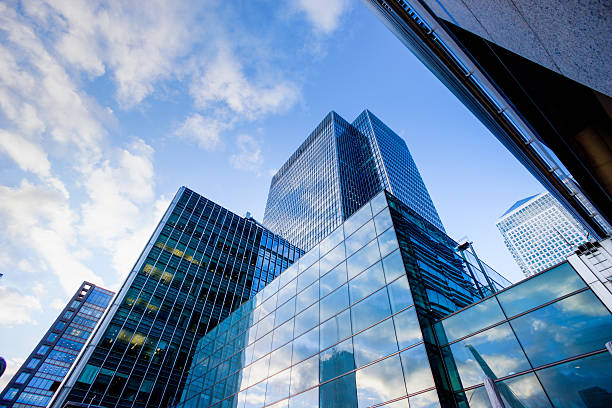

In [101]:
import requests
from PIL import Image
from io import BytesIO

# image 1 - Building
response = requests.get('https://media.istockphoto.com/id/511061090/photo/business-office-building-in-london-england.jpg?s=612x612&w=0&k=20&c=nYAn4JKoCqO1hMTjZiND1PAIWoABuy1BwH1MhaEoG6w=')
im = Image.open(BytesIO(response.content))
dummy_data = {"inputs": np.array(im)}
print("image 1 output: ", predictor_new.predict(dummy_data))
im

image 2 output:  {'forest': 1.0, 'glacier': 3.3811681753037615e-12, 'street': 4.019886095003866e-13, 'buildings': 7.100515921759643e-14, 'mountain': 4.154353049718937e-14}


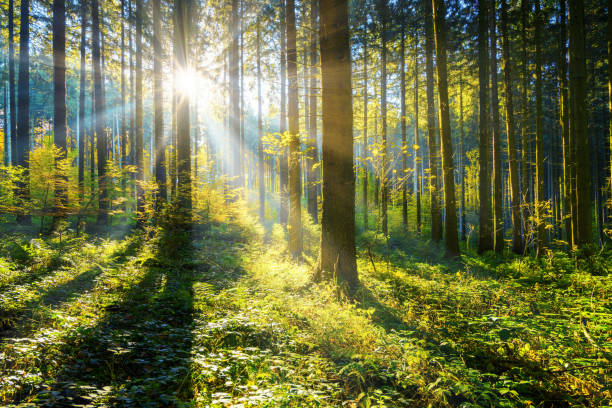

In [102]:
# image 2 - Forest
response = requests.get('https://media.istockphoto.com/id/901134626/photo/sun-shining-in-a-forest.jpg?s=612x612&w=0&k=20&c=Z1GPER9EE6BQK_efVKaSO7WODScQYOMPX3TFFPCZt88=')
im = Image.open(BytesIO(response.content))
dummy_data = {"inputs": np.array(im)}
print("image 2 output: ", predictor_new.predict(dummy_data))
im

image 3 output:  {'sea': 0.9968088269233704, 'glacier': 0.002899974351748824, 'mountain': 0.00027907415642403066, 'buildings': 6.61392050460563e-06, 'forest': 3.4542131288617384e-06}


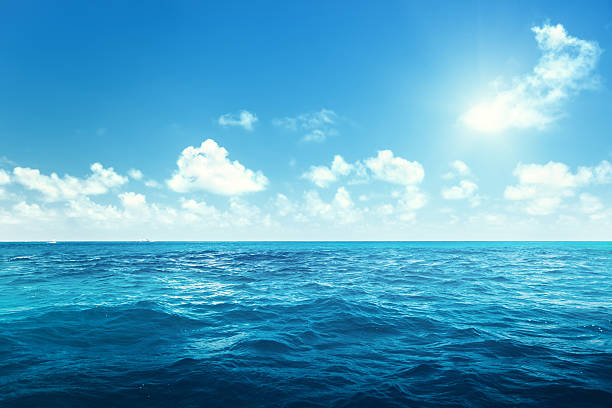

In [103]:
# image 3 - sea
response = requests.get('https://media.istockphoto.com/id/467367026/photo/perfect-sky-and-ocean.jpg?s=612x612&w=0&k=20&c=LZYFRxIhuKQom3l-kR3TLN7GikSJYJz9NRglQ3nngBw=')
im = Image.open(BytesIO(response.content))
dummy_data = {"inputs": np.array(im)}
print("image 3 output: ", predictor_new.predict(dummy_data))
im

image 4 output:  {'glacier': 0.995821475982666, 'sea': 0.0038411710411310196, 'mountain': 0.0003084829659201205, 'buildings': 1.7221886082552373e-05, 'forest': 6.988343557168264e-06}


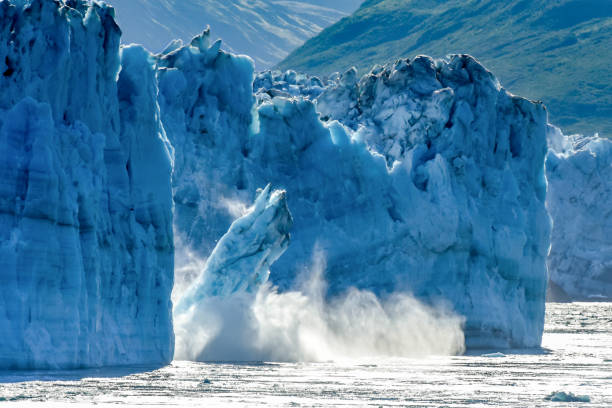

In [104]:
# image 4 - glacier
response = requests.get('https://media.istockphoto.com/id/1061549950/photo/calving-glacier-alaska-hubbard-glacier-a-huge-iceberg-calves-into-disenchantment-bay-st-elias.jpg?s=612x612&w=0&k=20&c=ri7A1uiTq5PI5iSxzmt22oAAOtrizXffP4JvA6nFTf4=')
im = Image.open(BytesIO(response.content))
dummy_data = {"inputs": np.array(im)}
print("image 4 output: ", predictor_new.predict(dummy_data))
im

image 5 output:  {'mountain': 0.920052707195282, 'glacier': 0.07909897714853287, 'buildings': 0.0007155901985242963, 'sea': 0.00012293385225348175, 'forest': 6.314934580586851e-06}


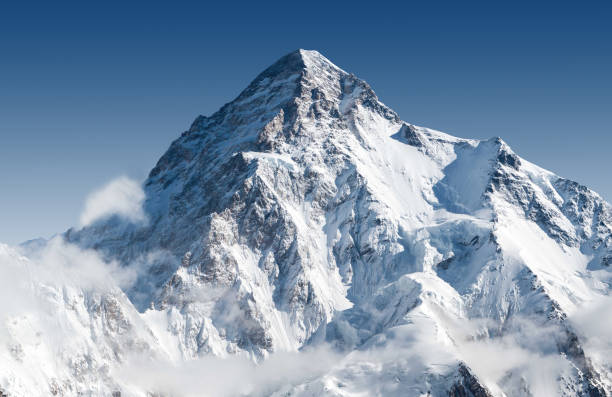

In [105]:
# image 5 - mountain
response = requests.get('https://media.istockphoto.com/id/1288385045/photo/snowcapped-k2-peak.jpg?s=612x612&w=0&k=20&c=sfA4jU8kXKZZqQiy0pHlQ4CeDR0DxCxXhtuTDEW81oo=')
im = Image.open(BytesIO(response.content))
dummy_data = {"inputs": np.array(im)}
print("image 5 output: ", predictor_new.predict(dummy_data))
im

In [26]:
classnames = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

In [27]:
! wget -O daisy.jpg "https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/marguerite-daisy-types-1586981163.jpg"

--2022-12-23 05:51:34--  https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/marguerite-daisy-types-1586981163.jpg
Resolving hips.hearstapps.com (hips.hearstapps.com)... 151.101.152.155
Connecting to hips.hearstapps.com (hips.hearstapps.com)|151.101.152.155|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 158008 (154K) [image/jpeg]
Saving to: ‘daisy.jpg’

daisy.jpg           100%[===================>] 154.30K  --.-KB/s    in 0.002s  

2022-12-23 05:51:34 (100 MB/s) - ‘daisy.jpg’ saved [158008/158008]



In [28]:
import torch

import torchvision.transforms as T
import torch.nn.functional as F

from PIL import Image

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [29]:
daisy_im = Image.open("daisy.jpg")

We could have done all this in infer.py as well, but today we are being verbose :p

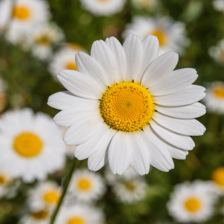

In [30]:
daisy_im.resize((224, 224))

In [31]:
transforms = T.Compose([
    T.ToTensor(),
    T.Resize((224, 224)),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [32]:
daisy_img_t = transforms(daisy_im)

In [33]:
daisy_input = {"inputs": daisy_img_t[None, ...].numpy().tolist()}

In [34]:
out = predictor_new.predict(daisy_input)

In [36]:
out_t = torch.tensor(out)

In [37]:
out_t.shape

torch.Size([1, 5])

In [40]:
out

[[0.0,
  -30.80523681640625,
  -53.81794738769531,
  -31.324243545532227,
  -50.847564697265625]]

In [38]:
F.softmax(out_t, dim=-1) 

tensor([[1.0000e+00, 4.1827e-14, 4.2380e-24, 2.4892e-14, 8.2639e-23]])

In [39]:
f"Prediction: {classnames[torch.argmax(out_t, dim=-1)[0]]}"

'Prediction: daisy'

### Testing

In [3]:
! pip install --quiet timm pytorch-lightning


[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: pip install --upgrade pip


In [36]:
from typing import Any, Dict, Optional, Tuple

import os
import subprocess
import torch
import timm

import pytorch_lightning as pl
import torchvision.transforms as T
import torch.nn.functional as F

from pathlib import Path
from torchvision.datasets import ImageFolder
from pytorch_lightning.plugins.environments import LightningEnvironment
from torch.utils.data import DataLoader, Dataset
from torchmetrics.functional import accuracy

In [37]:
class LitResnet(pl.LightningModule):
    def __init__(self, num_classes=10, lr=0.05):
        super().__init__()

        self.save_hyperparameters()
        self.model = timm.create_model('resnet18', pretrained=True)

    def forward(self, x):
        out = self.model(x)
        return F.log_softmax(out, dim=1)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        self.log("train_loss", loss)
        return loss

    def evaluate(self, batch, stage=None):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = accuracy(preds, y)

        if stage:
            self.log(f"{stage}/loss", loss, prog_bar=True)
            self.log(f"{stage}/acc", acc, prog_bar=True)

    def validation_step(self, batch, batch_idx):
        self.evaluate(batch, "val")

    def test_step(self, batch, batch_idx):
        self.evaluate(batch, "test")

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(
            self.parameters(),
            lr=self.hparams.lr,
            momentum=0.9,
            weight_decay=5e-4,
        )
        return {"optimizer": optimizer}


In [38]:
class FlowerDataModule(pl.LightningDataModule):
    def __init__(
        self,
        data_dir: str = "data/",
        batch_size: int = 64,
        num_workers: int = 0,
        pin_memory: bool = False,
    ):
        super().__init__()

        # this line allows to access init params with 'self.hparams' attribute
        # also ensures init params will be stored in ckpt
        self.save_hyperparameters(logger=False)
        
        self.data_dir = Path(data_dir)

        # data transformations
        self.transforms = T.Compose([
            T.ToTensor(),
            T.Resize((224, 224)),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        self.data_train: Optional[Dataset] = None
        self.data_test: Optional[Dataset] = None

    @property
    def num_classes(self):
        return len(self.data_train.classes)
    
    @property
    def classes(self):
        return self.data_train.classes

    def prepare_data(self):
        """Download data if needed.
        Do not use it to assign state (self.x = y).
        """
        pass

    def setup(self, stage: Optional[str] = None):
        """Load data. Set variables: `self.data_train`, `self.data_val`, `self.data_test`.
        This method is called by lightning with both `trainer.fit()` and `trainer.test()`, so be
        careful not to execute things like random split twice!
        """
        # load and split datasets only if not loaded already
        if not self.data_train and not self.data_test:
            trainset = ImageFolder(self.data_dir / "train", transform=self.transforms)
            testset = ImageFolder(self.data_dir / "test", transform=self.transforms)
            
            self.data_train, self.data_test = trainset, testset

    def train_dataloader(self):
        return DataLoader(
            dataset=self.data_train,
            batch_size=self.hparams.batch_size,
            num_workers=self.hparams.num_workers,
            pin_memory=self.hparams.pin_memory,
            shuffle=True,
        )

    def val_dataloader(self):
        return DataLoader(
            dataset=self.data_train,
            batch_size=self.hparams.batch_size,
            num_workers=self.hparams.num_workers,
            pin_memory=self.hparams.pin_memory,
            shuffle=False,
        )

    def test_dataloader(self):
        return DataLoader(
            dataset=self.data_test,
            batch_size=self.hparams.batch_size,
            num_workers=self.hparams.num_workers,
            pin_memory=self.hparams.pin_memory,
            shuffle=False,
        )

    def teardown(self, stage: Optional[str] = None):
        """Clean up after fit or test."""
        pass

    def state_dict(self):
        """Extra things to save to checkpoint."""
        return {}

    def load_state_dict(self, state_dict: Dict[str, Any]):
        """Things to do when loading checkpoint."""
        pass



In [39]:
datamodule = FlowerDataModule(data_dir=(Path("/root/flower-project/example-git/") / "dataset").absolute())
datamodule.setup()

In [40]:
datamodule.num_classes

5

In [41]:
model = LitResnet(num_classes=datamodule.num_classes)

INFO:timm.models.helpers:Loading pretrained weights from url (https://download.pytorch.org/models/resnet18-5c106cde.pth)


In [42]:
trainer = pl.Trainer(
    max_epochs=2,
    accelerator="auto",
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [43]:
trainer.fit(model, datamodule)


  | Name  | Type   | Params
---------------------------------
0 | model | ResNet | 11.7 M
---------------------------------
11.7 M    Trainable params
0         Non-trainable params
11.7 M    Total params
46.758    Total estimated model params size (MB)


Epoch 0:   3%|▎         | 3/102 [00:32<18:06, 10.97s/it, loss=5.55, v_num=4]

/opt/conda/lib/python3.8/site-packages/pytorch_lightning/trainer/call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")
